<hr style="height:4px;border-width:10;color:blue;background-color:black">



<img src="img/logo3.png" alt="Smiley face" width="50" height="50" style="float:left">


# MonReader


<hr style="height:4px;border-width:10;color:blue;background-color:black">

<br><br>

<hr style="height:2px;border-width:10;color:blue;background-color:black">

<img src="https://media1.giphy.com/media/KEAj1Hni8vLc0JcHpC/giphy.gif?cid=790b761137e5bc4519fcfbd3ec0229bda95e6655ace51675&rid=giphy.gif&ct=s" alt="Smiley face" width="60" height="60" style="float:left">

## INTRODUCTION
<hr style="height:2px;border-width:10;color:blue;background-color:black">


The project will be divided into two main sections: 
- Images preprocessing 
- Modeling: data will be feed into CNN(Convolutional Neural Network).

And now let's start with importing the needed library, set the seeds and read the data...

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

import matplotlib
matplotlib.style.use('ggplot')

In [2]:
# Set a seed value
seed_value= 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

I will read the data from [drive](https://drive.google.com/file/d/1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm/view?usp=sharing) and unzip the images

In [3]:
!gdown --id 1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm
!unzip images.zip

Downloading...
From: https://drive.google.com/uc?id=1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm
To: /content/images.zip
100% 940M/940M [00:18<00:00, 51.4MB/s]
Archive:  images.zip
   creating: images/
   creating: images/testing/
   creating: images/testing/flip/
  inflating: images/testing/flip/0001_000000020.jpg  
  inflating: images/testing/flip/0002_000000012.jpg  
  inflating: images/testing/flip/0002_000000013.jpg  
  inflating: images/testing/flip/0002_000000015.jpg  
  inflating: images/testing/flip/0002_000000017.jpg  
  inflating: images/testing/flip/0003_000000005.jpg  
  inflating: images/testing/flip/0003_000000008.jpg  
  inflating: images/testing/flip/0003_000000022.jpg  
  inflating: images/testing/flip/0003_000000025.jpg  
  inflating: images/testing/flip/0004_000000006.jpg  
  inflating: images/testing/flip/0004_000000013.jpg  
  inflating: images/testing/flip/0004_000000014.jpg  
  inflating: images/testing/flip/0004_000000027.jpg  
  inflating: images/testing/flip/0005_000000

In [4]:
pip install split-folders


Since we have two folders (train/test), I will split the train folder to train and validate data...

In [5]:
import splitfolders
splitfolders.ratio('images/training', output="images/dataset", seed=seed_value, ratio=(0.8, 0.2)) 

Copying files: 2392 files [00:11, 212.48 files/s]


<hr style="height:2px;border-width:10;color:blue;background-color:black">

<img src="https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/5eeea355389655.59822ff824b72.gif" alt="Smiley face" width="70" height="70" align="left">

## DATA PREPROCESSING
<hr style="height:2px;border-width:10;color:blue;background-color:black">


In [6]:
# how many samples per batch to load
batch_size = 20
# images classes
classes = ['flip', 'notflip']

Before doing antthing, I will convert part of the data which is the train data to tensors just to see what the images looks like by using the `im_convert` function.

In [7]:
train_data = ImageFolder('images/dataset/train', transform=transforms.Compose([transforms.ToTensor(),
                                                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                                                   [0.229, 0.224, 0.225])]))
                                                                               
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [8]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

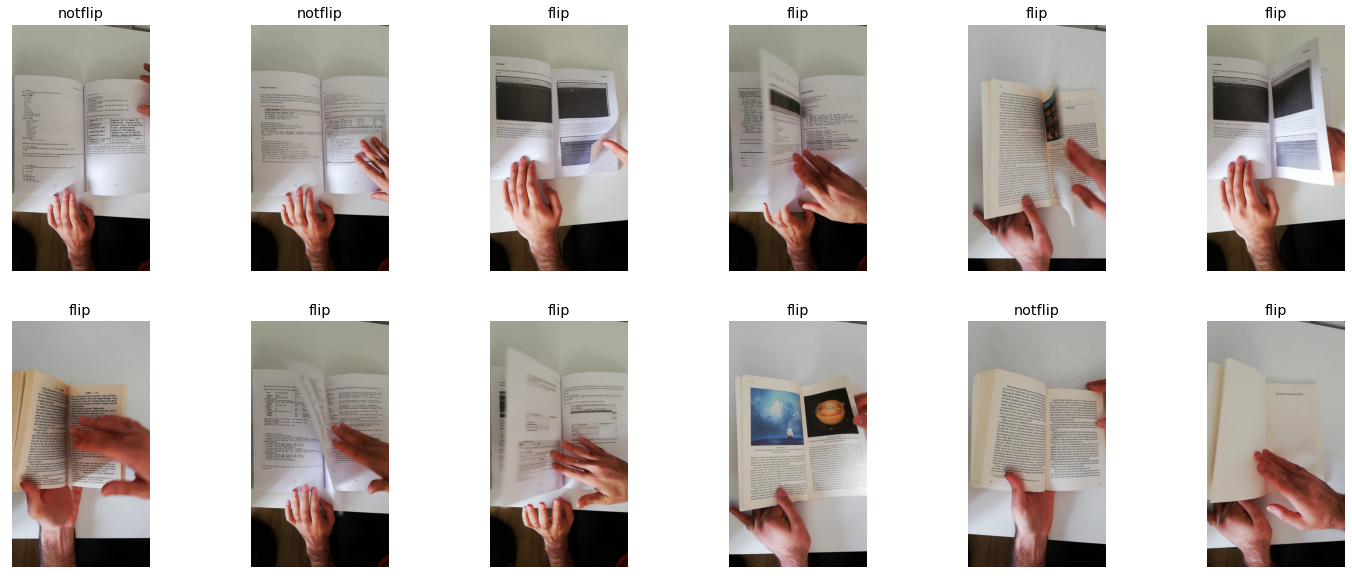

In [9]:
sample = next(iter(training_loader))
images, labels = sample
# display the images
fig = plt.figure(figsize=(25, 10))
# content and style ims side-by-side
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    ax.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i]])

As we can see, there are two classes, `filp` and `notflip` class. In all images, there is a hand and a space around the page, we will reduce this space later.

For preprocessing, I will:
-  Reduce the image size to 224, 224 px for all the images.
- Flipping the images horizontally and vertically with a random probability, only for training images.
- Normalizing all the pixel values for all the images.
- And finally, transform all the images into tensors.

In [10]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resizing all the images to 224×224 dimensions.
        transforms.RandomHorizontalFlip(), # Flipping the images horizontally and vertically with a random probability.
        transforms.RandomVerticalFlip(),
        
        transforms.ToTensor(), # Converting the images to tensors which divides all the pixel values by 255.0 and changes the dimension format to [channel, height, width].
        transforms.ColorJitter(), # Randomly change the brightness, contrast, saturation and hue of an image
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizing all the pixel values by using the ImageNet normalization stats.
                             std=[0.229, 0.224, 0.225])])

test_val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

train_data = ImageFolder('images/dataset/train', transform=train_transform)
val_data = ImageFolder('images/dataset/val', transform=test_val_transform)
test_data = ImageFolder('images/testing', transform=test_val_transform)

    
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
   
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("No. of batches in train loader:{}".format(len(train_loader))) 
print("No. of total train examples:{}".format(len(train_loader.dataset)))


print("No. of batches in validation loader:{}".format(len(valid_loader))) 
print("No. of total valid  examples:{}".format(len(valid_loader.dataset)))


print("No. of batches in test loader:{}".format(len(test_loader))) 
print("No. of total test examples:{}".format(len(test_loader.dataset)))

No. of batches in train loader:96
No. of total train examples:1913
No. of batches in validation loader:24
No. of total valid  examples:479
No. of batches in test loader:30
No. of total test examples:597


Let's see the images after processing...

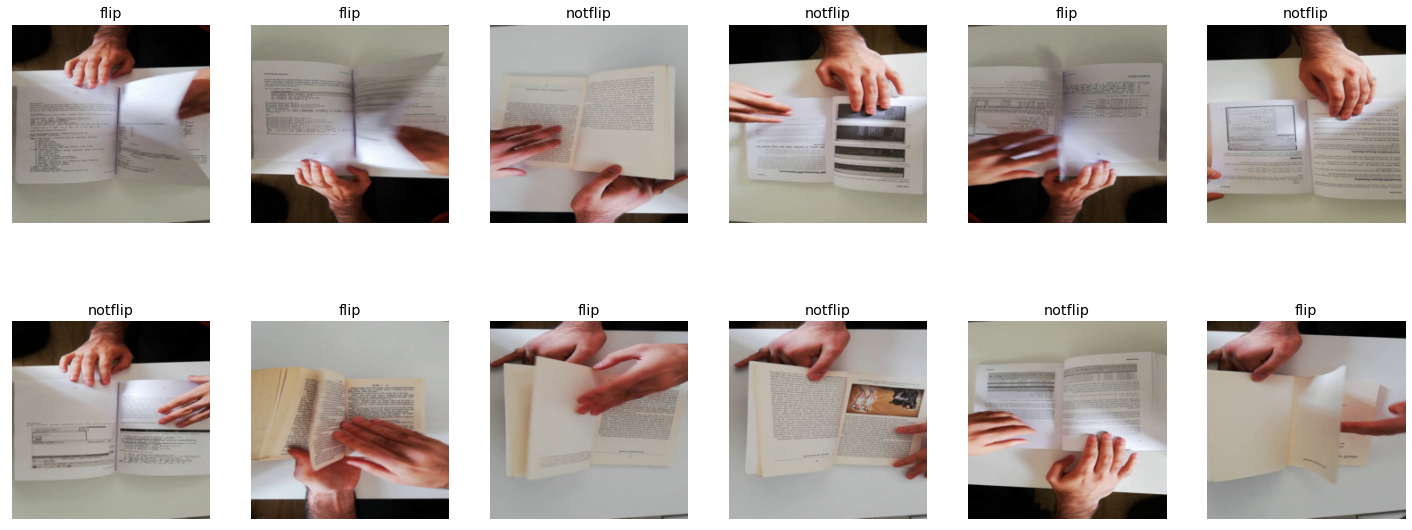

In [11]:
sample = next(iter(train_loader))
images, labels = sample
# display the images
fig = plt.figure(figsize=(25, 10))
# content and style ims side-by-side
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    ax.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i]])

We can see the size of the images has been reduced and image Flipping was applied randomly. At this point, the images are ready for modelling.

<hr style="height:2px;border-width:10;color:blue;background-color:black">

<img src="https://i2.wp.com/i.giphy.com/media/JtB1c2fFBtxFfd3M4Q/giphy.gif" alt="Smiley face" width="60" height="60" align="left">

## MACHINE LEARNING
<hr style="height:2px;border-width:10;color:blue;background-color:black">


I will use the pre-trained `Efficient Net` model and edit the last layers to match our classes number.

In [12]:
efficientnet_b4_model = models.efficientnet_b4(pretrained=True)

# Freeze training for all "features" layers
for param in efficientnet_b4_model.features.parameters():
    param.requires_grad = False

n_inputs = efficientnet_b4_model.classifier[1].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

efficientnet_b4_model.classifier[1] = last_layer


print(efficientnet_b4_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# total parameters and trainable parameters
total_params = sum(p.numel() for p in efficientnet_b4_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in efficientnet_b4_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# strings to save the loss plot and accuracy plot different names according to the training type
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'


Computation device: cpu

17,552,202 total parameters.
3,586 training parameters.


Also, I will use both of `Learning rate scheduler` and `Early stopping` with my model.

In [14]:
class LRScheduler():
  """
  Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
  """

  def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
    """
    new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
    """

    self.optimizer = optimizer
    self.patience = patience
    self.min_lr = min_lr
    self.factor = factor


    self.lr_schedluler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=self.patience, factor=self.factor, min_lr=self.min_lr, verbose=True)


  def __call__(self, val_loss):
    self.lr_schedluler.step(val_loss)


In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [16]:
def fit(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [17]:
# validation function
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [18]:
# to upload my model to Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [19]:
# learning parameters 
lr = 0.001
epochs = 1000

# optimizer
optimizer = optim.Adam(efficientnet_b4_model.parameters(), lr=lr)

# loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler 
lr_scheduler = LRScheduler(optimizer)

# Early stopping
early_stopping = EarlyStopping()

In [20]:
def training(model, file_name):
  # lists to store per-epoch loss and accuracy values
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf 
  train_loss, train_accuracy = [], []
  val_loss, val_accuracy = [], []
  start = time.time()
  for epoch in range(epochs):
      print(f"Epoch {epoch+1} of {epochs}")
      train_epoch_loss, train_epoch_accuracy = fit(
          model, train_loader, train_data, optimizer, criterion
      )
      val_epoch_loss, val_epoch_accuracy = validate(
          model, valid_loader, val_data, criterion
      )
      train_loss.append(train_epoch_loss)
      train_accuracy.append(train_epoch_accuracy)
      val_loss.append(val_epoch_loss)
      val_accuracy.append(val_epoch_accuracy)
      lr_scheduler(val_epoch_loss)
      early_stopping(val_epoch_loss)
      if early_stopping.early_stop:
          break
      print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
      print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
      
      
      if val_epoch_loss < valid_loss_min:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/project_4/{file_name}")
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,val_epoch_loss))
            valid_loss_min = val_epoch_loss
  end = time.time()
  print(f"Training time: {(end-start)/60:.3f} minutes")


  print('Saving loss and accuracy plots...')
  # accuracy plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label='train accuracy')
  plt.plot(val_accuracy, color='blue', label='validataion accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/project_4/{acc_plot_name}.png")
  plt.show()
  # loss plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_loss, color='orange', label='train loss')
  plt.plot(val_loss, color='red', label='validataion loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/project_4/{loss_plot_name}.png")
  plt.show()
      
  
  print('TRAINING COMPLETE')

Let's train our model...

Epoch 1 of 1000
Training


96it [07:40,  4.80s/it]


Validating


24it [01:26,  3.60s/it]


Train Loss: 0.5935, Train Acc: 71.14
Val Loss: 0.5045, Val Acc: 79.54
Validation loss decreased (inf --> 0.504528).  Saving model ...
Epoch 2 of 1000
Training


96it [07:37,  4.76s/it]


Validating


24it [01:25,  3.58s/it]


Train Loss: 0.4781, Train Acc: 80.97
Val Loss: 0.4480, Val Acc: 80.17
Validation loss decreased (0.504528 --> 0.447992).  Saving model ...
Epoch 3 of 1000
Training


96it [07:36,  4.76s/it]


Validating


24it [01:25,  3.58s/it]


Train Loss: 0.4159, Train Acc: 84.68
Val Loss: 0.3930, Val Acc: 84.13
Validation loss decreased (0.447992 --> 0.392986).  Saving model ...
Epoch 4 of 1000
Training


96it [07:36,  4.75s/it]


Validating


24it [01:25,  3.56s/it]


Train Loss: 0.3789, Train Acc: 86.46
Val Loss: 0.3620, Val Acc: 86.43
Validation loss decreased (0.392986 --> 0.361964).  Saving model ...
Epoch 5 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.55s/it]


Train Loss: 0.3701, Train Acc: 85.31
Val Loss: 0.3212, Val Acc: 89.14
Validation loss decreased (0.361964 --> 0.321245).  Saving model ...
Epoch 6 of 1000
Training


96it [07:36,  4.75s/it]


Validating


24it [01:25,  3.57s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.3442, Train Acc: 86.51
Val Loss: 0.3221, Val Acc: 88.94
Epoch 7 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.58s/it]


Train Loss: 0.3358, Train Acc: 86.57
Val Loss: 0.2976, Val Acc: 89.77
Validation loss decreased (0.321245 --> 0.297631).  Saving model ...
Epoch 8 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.56s/it]


Train Loss: 0.3366, Train Acc: 85.52
Val Loss: 0.2924, Val Acc: 89.77
Validation loss decreased (0.297631 --> 0.292351).  Saving model ...
Epoch 9 of 1000
Training


96it [07:35,  4.74s/it]


Validating


24it [01:25,  3.56s/it]


Train Loss: 0.3198, Train Acc: 88.13
Val Loss: 0.2805, Val Acc: 90.40
Validation loss decreased (0.292351 --> 0.280500).  Saving model ...
Epoch 10 of 1000
Training


96it [07:36,  4.76s/it]


Validating


24it [01:26,  3.60s/it]


Train Loss: 0.3067, Train Acc: 87.51
Val Loss: 0.2726, Val Acc: 90.40
Validation loss decreased (0.280500 --> 0.272635).  Saving model ...
Epoch 11 of 1000
Training


96it [07:40,  4.79s/it]


Validating


24it [01:26,  3.60s/it]


Train Loss: 0.2975, Train Acc: 88.97
Val Loss: 0.2724, Val Acc: 90.40
Validation loss decreased (0.272635 --> 0.272448).  Saving model ...
Epoch 12 of 1000
Training


96it [07:39,  4.78s/it]


Validating


24it [01:26,  3.59s/it]


Train Loss: 0.3028, Train Acc: 87.56
Val Loss: 0.2620, Val Acc: 91.23
Validation loss decreased (0.272448 --> 0.262007).  Saving model ...
Epoch 13 of 1000
Training


96it [07:37,  4.77s/it]


Validating


24it [01:25,  3.55s/it]


Train Loss: 0.2892, Train Acc: 88.81
Val Loss: 0.2522, Val Acc: 92.07
Validation loss decreased (0.262007 --> 0.252233).  Saving model ...
Epoch 14 of 1000
Training


96it [07:39,  4.78s/it]


Validating


24it [01:27,  3.63s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2906, Train Acc: 88.03
Val Loss: 0.2587, Val Acc: 90.81
Epoch 15 of 1000
Training


96it [07:35,  4.74s/it]


Validating


24it [01:25,  3.55s/it]


INFO: Early stopping counter 2 of 5
Train Loss: 0.2937, Train Acc: 88.03
Val Loss: 0.2577, Val Acc: 90.40
Epoch 16 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.56s/it]


Train Loss: 0.3010, Train Acc: 87.98
Val Loss: 0.2465, Val Acc: 91.65
Validation loss decreased (0.252233 --> 0.246479).  Saving model ...
Epoch 17 of 1000
Training


96it [07:35,  4.74s/it]


Validating


24it [01:25,  3.55s/it]


Train Loss: 0.2787, Train Acc: 88.71
Val Loss: 0.2321, Val Acc: 92.07
Validation loss decreased (0.246479 --> 0.232096).  Saving model ...
Epoch 18 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.56s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2776, Train Acc: 88.92
Val Loss: 0.2528, Val Acc: 90.81
Epoch 19 of 1000
Training


96it [07:34,  4.73s/it]


Validating


24it [01:25,  3.58s/it]


Train Loss: 0.2740, Train Acc: 88.71
Val Loss: 0.2284, Val Acc: 92.07
Validation loss decreased (0.232096 --> 0.228377).  Saving model ...
Epoch 20 of 1000
Training


96it [07:34,  4.74s/it]


Validating


24it [01:25,  3.56s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2856, Train Acc: 88.03
Val Loss: 0.2310, Val Acc: 91.44
Epoch 21 of 1000
Training


96it [07:37,  4.76s/it]


Validating


24it [01:25,  3.55s/it]


Train Loss: 0.2627, Train Acc: 89.96
Val Loss: 0.2162, Val Acc: 92.69
Validation loss decreased (0.228377 --> 0.216154).  Saving model ...
Epoch 22 of 1000
Training


96it [07:36,  4.75s/it]


Validating


24it [01:36,  4.03s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2675, Train Acc: 88.76
Val Loss: 0.2272, Val Acc: 91.86
Epoch 23 of 1000
Training


96it [07:39,  4.79s/it]


Validating


24it [01:26,  3.59s/it]


Train Loss: 0.2833, Train Acc: 88.50
Val Loss: 0.2151, Val Acc: 92.07
Validation loss decreased (0.216154 --> 0.215105).  Saving model ...
Epoch 24 of 1000
Training


96it [07:37,  4.77s/it]


Validating


24it [01:27,  3.66s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2749, Train Acc: 88.60
Val Loss: 0.2266, Val Acc: 90.81
Epoch 25 of 1000
Training


96it [07:34,  4.74s/it]


Validating


24it [01:26,  3.59s/it]


Train Loss: 0.2593, Train Acc: 89.07
Val Loss: 0.2132, Val Acc: 92.48
Validation loss decreased (0.215105 --> 0.213171).  Saving model ...
Epoch 26 of 1000
Training


96it [07:50,  4.90s/it]


Validating


24it [01:25,  3.56s/it]


INFO: Early stopping counter 1 of 5
Train Loss: 0.2693, Train Acc: 88.97
Val Loss: 0.2168, Val Acc: 91.86
Epoch 27 of 1000
Training


96it [07:35,  4.74s/it]


Validating


24it [01:25,  3.58s/it]


INFO: Early stopping counter 2 of 5
Train Loss: 0.2668, Train Acc: 89.18
Val Loss: 0.2425, Val Acc: 91.02
Epoch 28 of 1000
Training


96it [07:34,  4.73s/it]


Validating


24it [01:25,  3.56s/it]


INFO: Early stopping counter 3 of 5
Train Loss: 0.2483, Train Acc: 90.22
Val Loss: 0.2208, Val Acc: 92.28
Epoch 29 of 1000
Training


96it [07:35,  4.75s/it]


Validating


24it [01:25,  3.58s/it]


INFO: Early stopping counter 4 of 5
Train Loss: 0.2590, Train Acc: 89.23
Val Loss: 0.2315, Val Acc: 90.40
Epoch 30 of 1000
Training


96it [07:33,  4.72s/it]


Validating


24it [01:25,  3.55s/it]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training time: 271.661 minutes
Saving loss and accuracy plots...


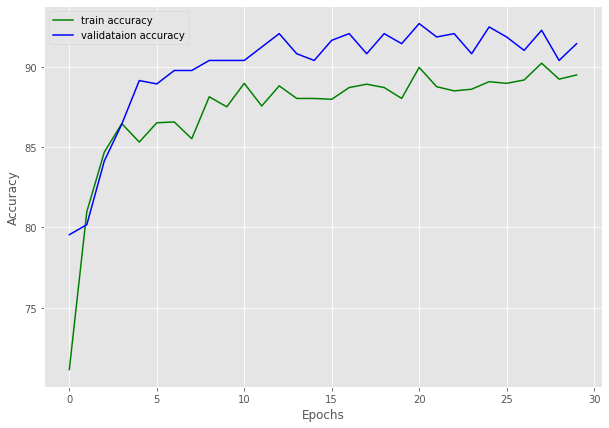

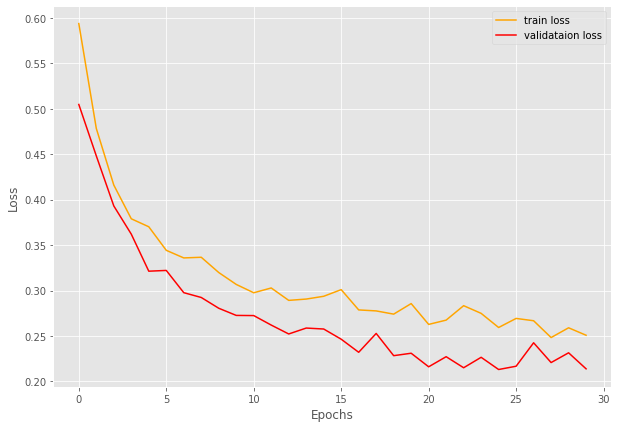

TRAINING COMPLETE


In [21]:
training(efficientnet_b4_model, 'efficientnet_b4_model.pt')

In [22]:
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/project_4/efficientnet_b4_model.pt')
efficientnet_b4_model.load_state_dict(state_dict)

<All keys matched successfully>

For calculating the test score, I will use the previous validation function since it's the same code.

In [23]:
validate(efficientnet_b4_model, test_loader, val_data, criterion)

Validating


30it [01:46,  3.55s/it]


(0.19244815967977047, 94.63986599664992)

Video

In [13]:
import cv2
import numpy as np
import glob
def video_creator(path_in, path_out, fps):
    img_array = []
    #  Fetch all the image file names using glob
    for filename in glob.glob(path_in):
        # Read all the images using cv2.imread()
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        # Store all the images into a list
        img_array.append(img)
    
    # Create a VideoWriter object using cv2.VideoWriter()
    out = cv2.VideoWriter(path_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    
    for i in range(len(img_array)):
        # Save the images to video file using cv2.VideoWriter().write()
        out.write(img_array[i])
    # Release the VideoWriter and destroy all windows.
    out.release()

In [17]:
video_creator(path_in='images/training/flip/*.jpg', path_out='/content/drive/MyDrive/Colab Notebooks/project_4/training_flip.avi', fps=1)
video_creator(path_in='images/training/notflip/*.jpg', path_out='/content/drive/MyDrive/Colab Notebooks/project_4/training_notflip.avi', fps=1)

video_creator(path_in='images/testing/flip/*.jpg', path_out='/content/drive/MyDrive/Colab Notebooks/project_4/testing_flip.avi', fps=1)
video_creator(path_in='images/testing/notflip/*.jpg', path_out='/content/drive/MyDrive/Colab Notebooks/project_4/testing_notflip.avi', fps=1)


In [18]:
from moviepy.editor import VideoFileClip, concatenate_videoclips


In [19]:
# Establish the training video by concatenating the flips with the not flips for train and test data sets.

#Establish the train video

video_1 = VideoFileClip('/content/drive/MyDrive/Colab Notebooks/project_4/training_flip.avi')
video_2 = VideoFileClip('/content/drive/MyDrive/Colab Notebooks/project_4/training_notflip.avi')

training_video = concatenate_videoclips([video_1, video_2])

training_video.write_videofile('/content/drive/MyDrive/Colab Notebooks/project_4/train_video_1.avi', codec = 'rawvideo')
training_video.close()

[MoviePy] >>>> Building video /content/drive/MyDrive/Colab Notebooks/project_4/train_video_1.avi
[MoviePy] Writing video /content/drive/MyDrive/Colab Notebooks/project_4/train_video_1.avi


100%|█████████▉| 2392/2393 [04:44<00:00,  8.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Colab Notebooks/project_4/train_video_1.avi 



In [20]:
# Establish the test video

video_3 = VideoFileClip('/content/drive/MyDrive/Colab Notebooks/project_4/testing_flip.avi')
video_4 = VideoFileClip('/content/drive/MyDrive/Colab Notebooks/project_4/testing_notflip.avi')

test_video= concatenate_videoclips([video_3, video_4])

test_video.write_videofile('/content/drive/MyDrive/Colab Notebooks/project_4/test_video_1.avi', codec = 'rawvideo')
test_video.close()

[MoviePy] >>>> Building video /content/drive/MyDrive/Colab Notebooks/project_4/test_video_1.avi
[MoviePy] Writing video /content/drive/MyDrive/Colab Notebooks/project_4/test_video_1.avi


100%|█████████▉| 597/598 [01:01<00:00,  9.77it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Colab Notebooks/project_4/test_video_1.avi 



<hr style="height:2px;border-width:10;color:blue;background-color:black">

<img src="https://media1.giphy.com/media/HL5fq93TXz4sW3u7EL/giphy.gif?cid=790b7611dead5ce6a99ec8a7ace650b2a30c46418e5f871c&rid=giphy.gif&ct=s" alt="Smiley face" width="60" height="60" style="float:left">

##   CONCLUSION
<hr style="height:2px;border-width:10;color:blue;background-color:black">
